# Entendimento dos dados

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler


warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv(os.getcwd()+'\\data\\raw\\segmentation_data.csv')
data.head(1)

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2


In [3]:
# ajustando nome das colunas
data.columns = data.columns.str.replace(' ', '_').str.lower()

data.head()

,id,sex,marital_status,age,education,income,occupation,settlement_size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


- Não utilizaremos a coluna `id`, portanto irei dropa-la.

In [4]:
data.drop(columns='id', inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   sex              2000 non-null   int64
 1   marital_status   2000 non-null   int64
 2   age              2000 non-null   int64
 3   education        2000 non-null   int64
 4   income           2000 non-null   int64
 5   occupation       2000 non-null   int64
 6   settlement_size  2000 non-null   int64
dtypes: int64(7)
memory usage: 109.5 KB


In [6]:
data.isnull().sum()

sex                0
marital_status     0
age                0
education          0
income             0
occupation         0
settlement_size    0
dtype: int64

In [7]:
data.duplicated().sum()

0

- Os dados apresentam tipagem correta
- Não há dados duplicados nem dados nulos

In [8]:
data.describe()

,sex,marital_status,age,education,income,occupation,settlement_size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


# Análise exploratória dos dados

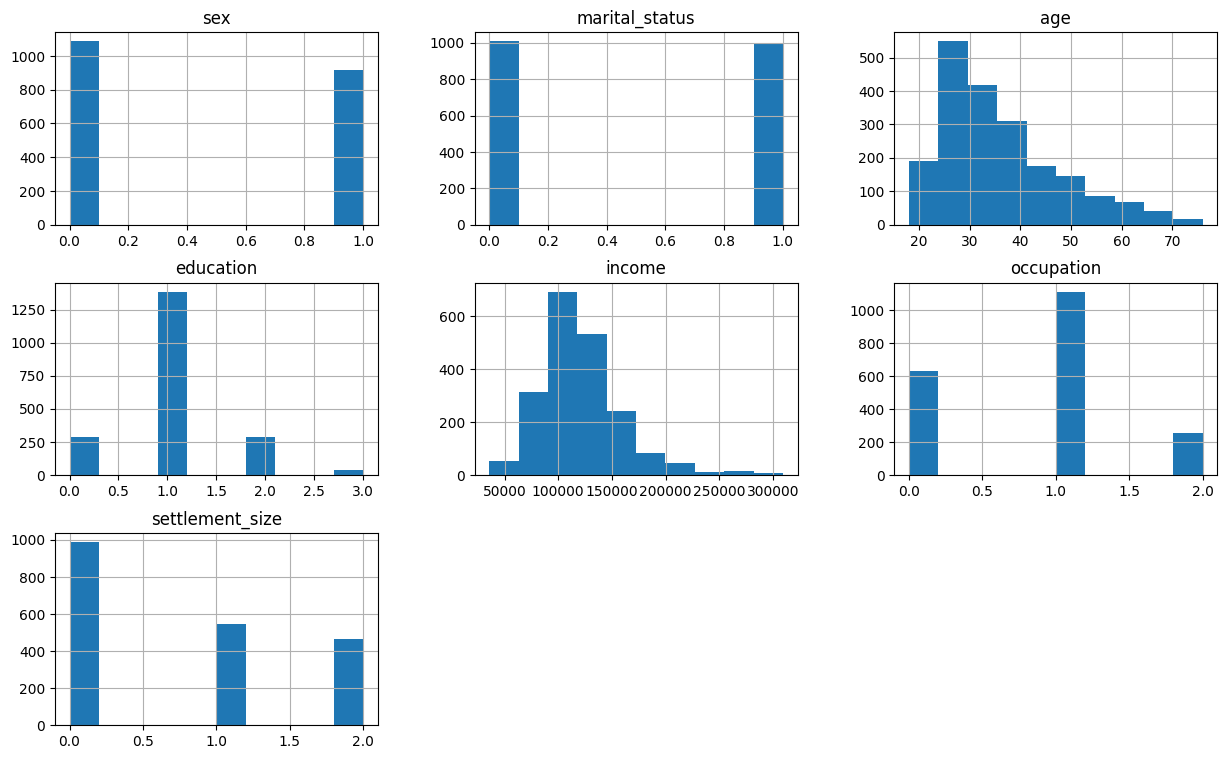

In [9]:
data.hist(figsize=(15,9));

- Analizando préviamente a distribuição dos dados notamos que a coluna `age` e `income` apresentam uma cauda longa e uma certa tentência ao lado esquedo do gráfico. Com o intuito de normalizar essa distribuição utilizaremos o método estatístico de logarítmo a fim de encontra essa normal na distribuição. 
- Este método é utilizado em caso de dados com distribuição desiguais, e funciona diminuindo a escala dos valores.

In [10]:
data['age'] = np.log(data['age'])
data['income'] = np.log(data['income'])

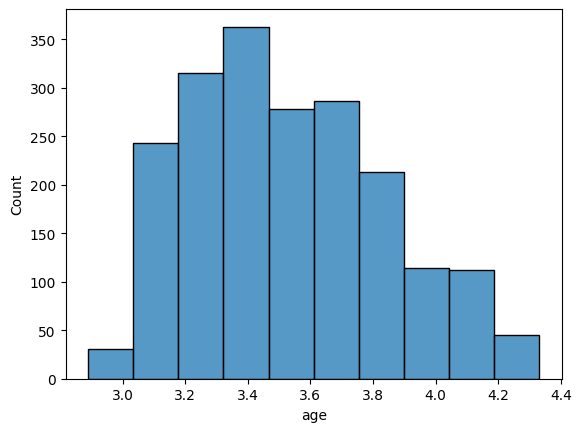

In [11]:
sns.histplot(data['age'], bins=10)
plt.show()

- A maioria dos registros em idade se encontram entre os 25-35 anos.

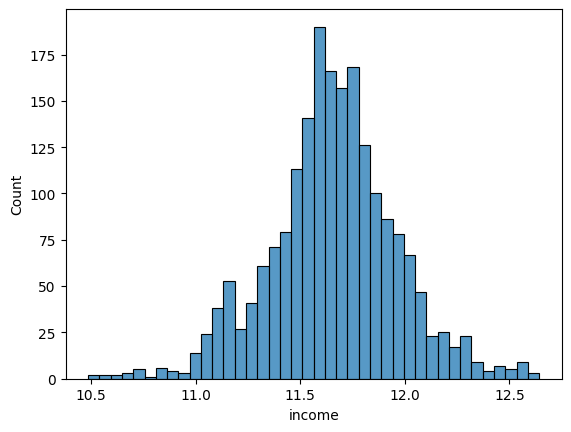

In [12]:
sns.histplot(data['income'])
plt.show()

- A renda média anual é em torno de 100 a 120 mil dólares

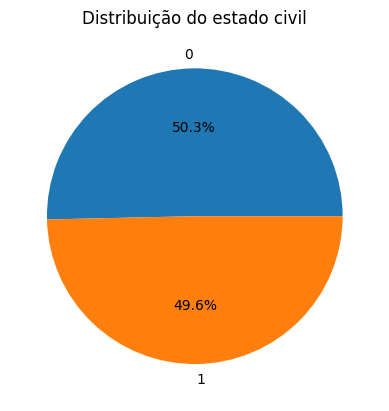

In [13]:
plt.pie(data['marital_status'].value_counts(), labels=data['marital_status'].unique(), autopct='%1.1f%%')
plt.title('Distribuição do estado civil')
plt.show()

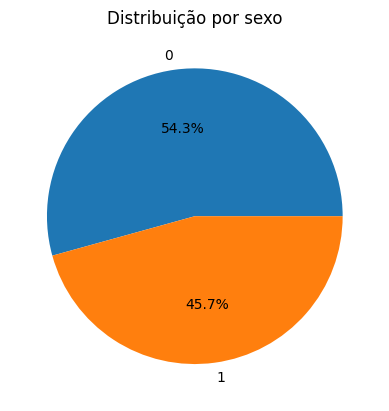

In [14]:
plt.pie(data['sex'].value_counts(), labels=data['sex'].unique(), autopct='%1.1f%%')
plt.title('Distribuição por sexo')
plt.show()

- Há mais homens registrados que mulheres

#### Estado civil  x  Sexo

<Axes: xlabel='marital_status', ylabel='count'>

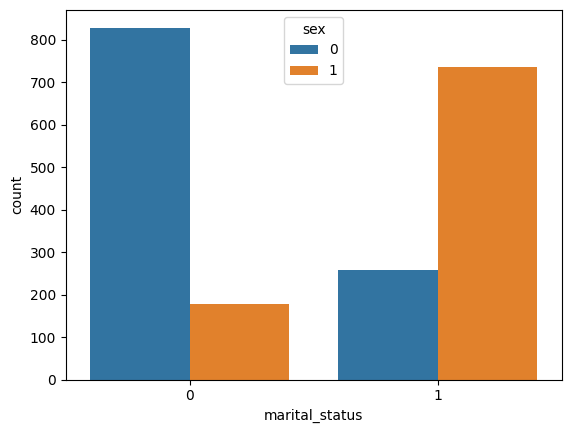

In [15]:
sns.countplot(data=data, x='marital_status', hue='sex')

- Podemos observar que q auntidade de homens solteiros são quase que 4x maior que o número de mulheres solteiras. 
- Já em relacionamento as mulheres apresentam mais que o dobro da quantidade de homens.

<Axes: xlabel='occupation', ylabel='count'>

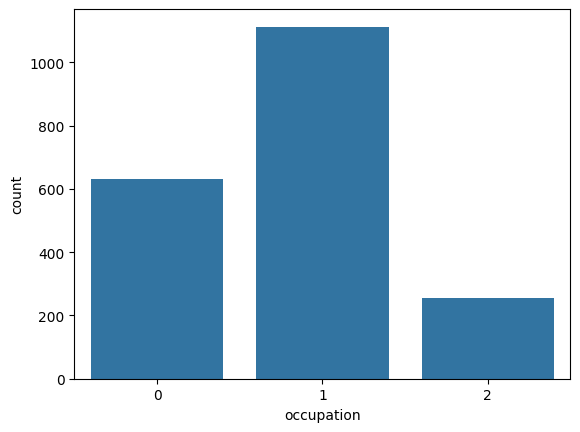

In [16]:
sns.countplot(x='occupation', data=data)

- O maior parte dos nossos clientes são empregados qualificados, em seguida temos os desempregados e por fim altamente qualificados

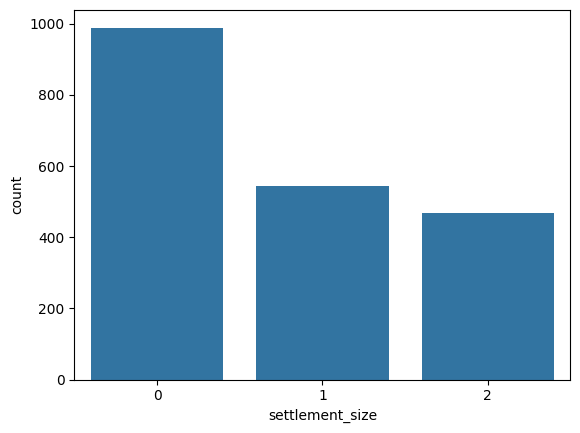

In [17]:
sns.countplot(x='settlement_size', data=data)
plt.show()

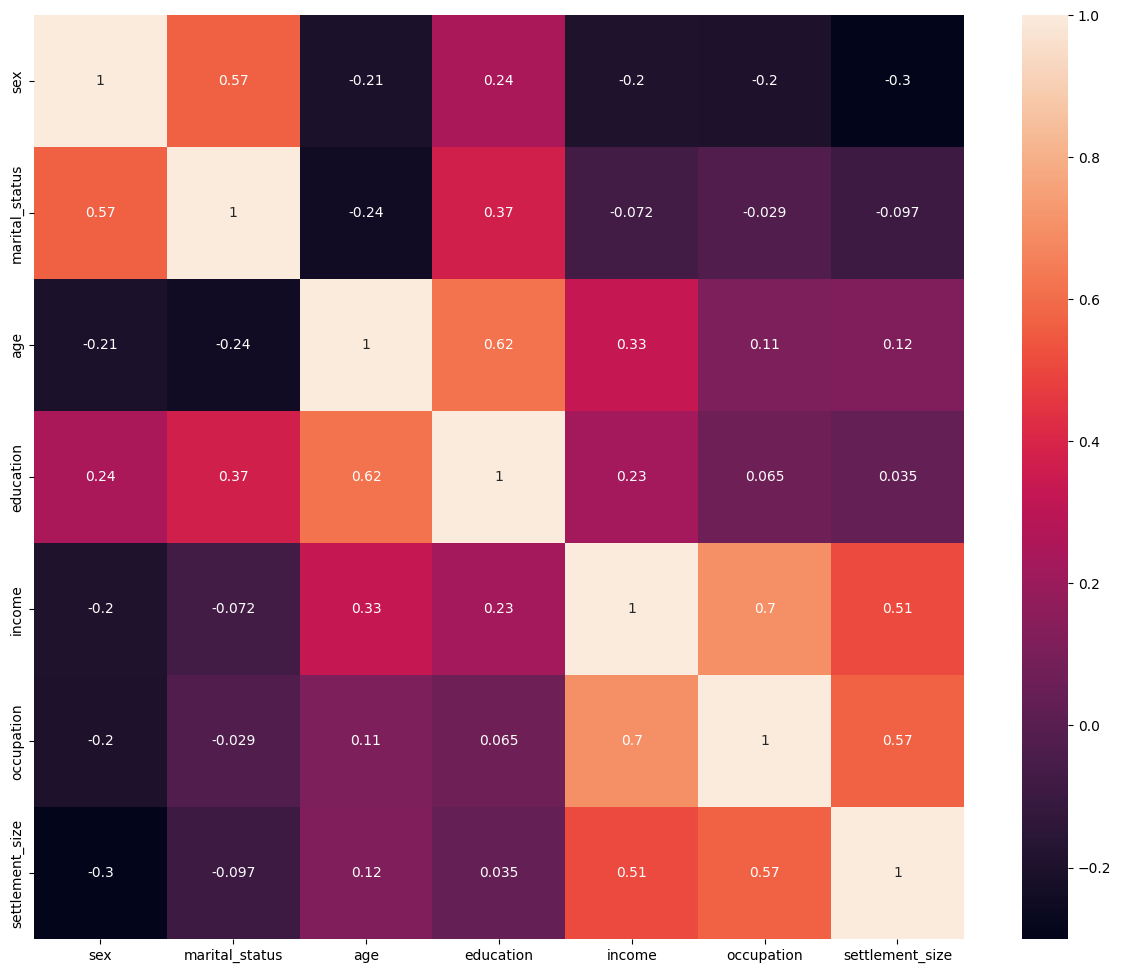

In [18]:
plt.figure(figsize=(15,12))
sns.heatmap(data.corr(), annot=True)
plt.show()

- Notamos uma correlação expressíva entre `occupation` e `income`. O que faz sentido, normalmente quanto maior a renda, melhor a regirão que reside a pessoa. 

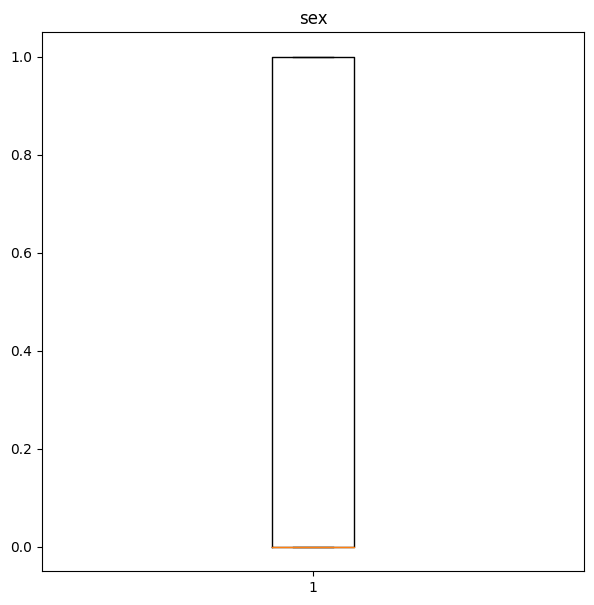

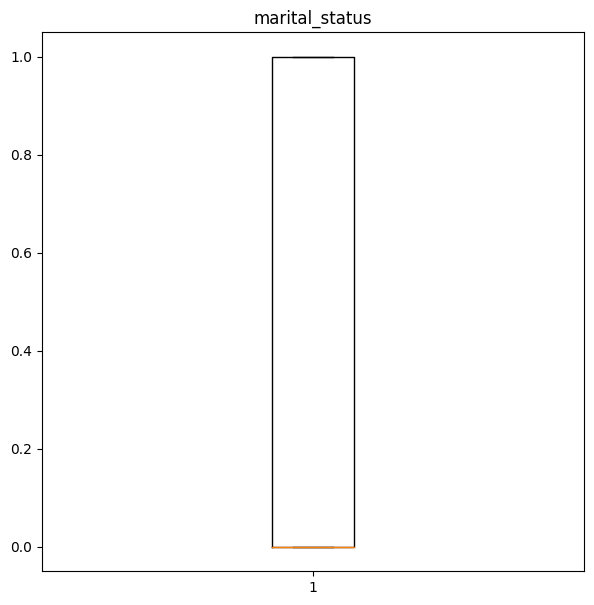

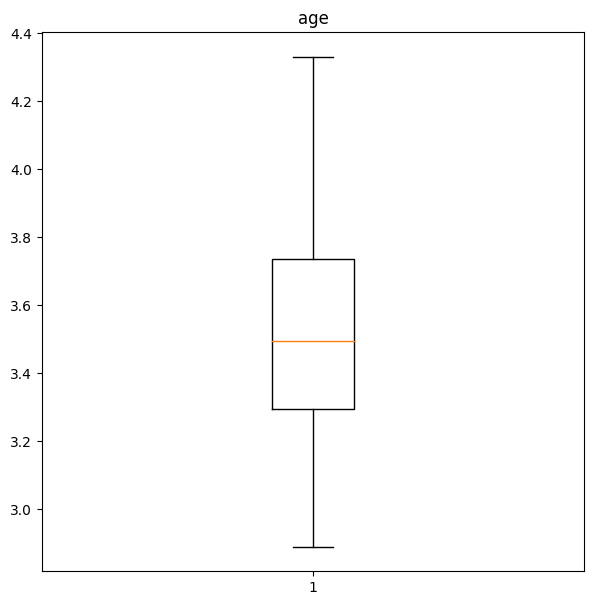

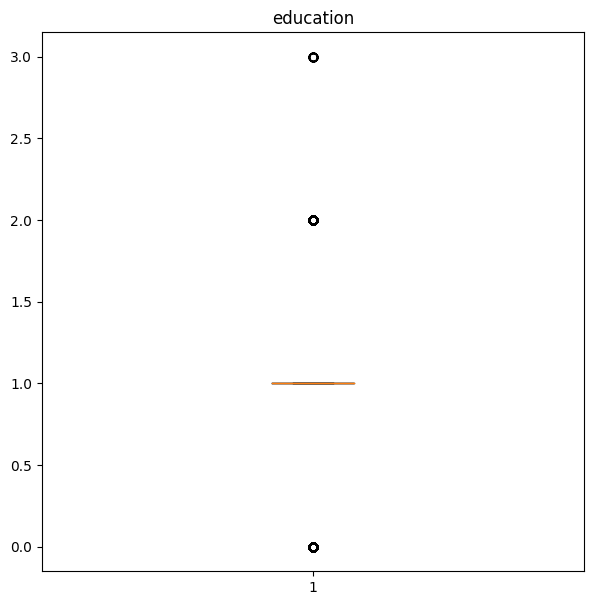

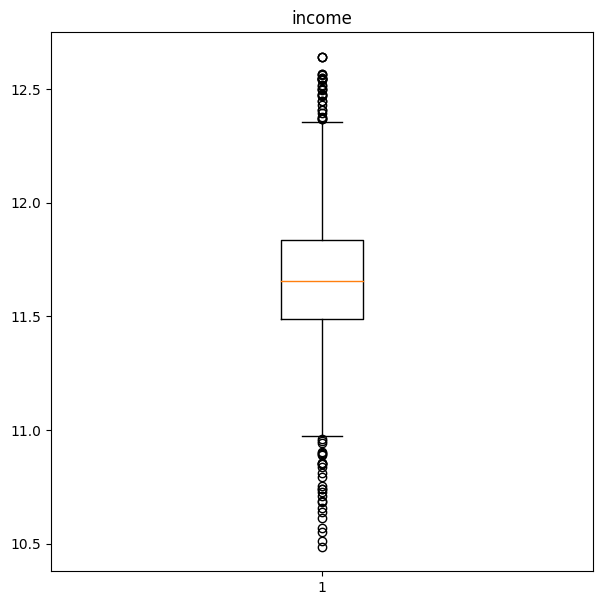

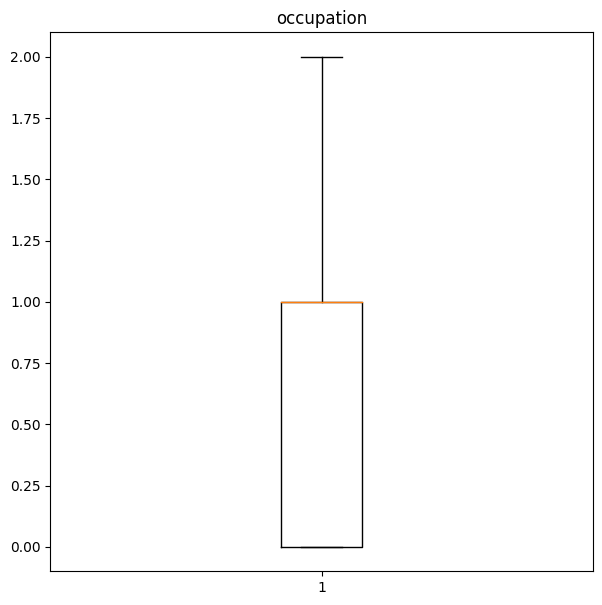

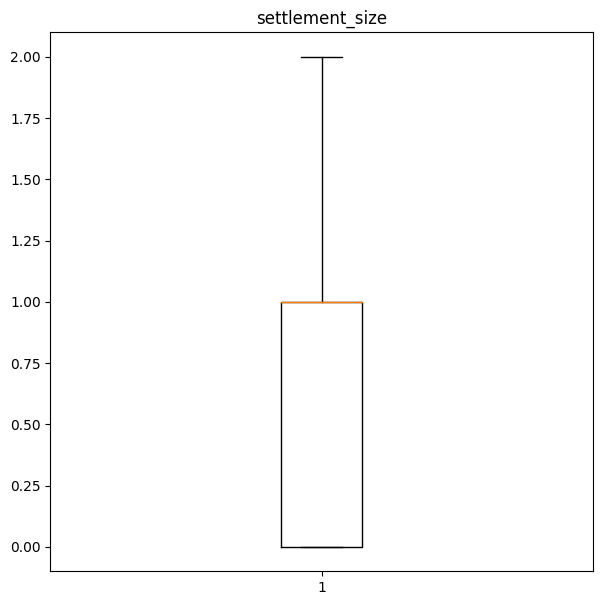

In [19]:
for col in data.columns:
    plt.figure(figsize=(7,7))
    plt.boxplot(data[col])
    plt.title(f'{col}')
    plt.show()

- Nossos dados não possuem outliers

# Modelagem de dados

In [20]:
x = data[['age', 'income']]

sc = RobustScaler()

x = sc.fit_transform(x)

x

array([[ 1.60283513,  0.21943558],
       [-0.91768912,  0.76847333],
       [ 0.89471126, -0.74713668],
       ...,
       [-0.14150231, -0.83957083],
       [-0.72075628, -0.47667503],
       [-0.62836387, -1.51359232]])

## K-means

#### Método de cotovelo para determinar o número de K

In [21]:
wcss = []
n_clusters = range(2,15)

for n in n_clusters:
    wcss.append(KMeans(n_clusters = n,init='k-means++', random_state=42).fit(x).inertia_)

In [22]:
wcss

[1422.6312066630917,
 1045.6872422096417,
 803.0832189838575,
 647.5144764470253,
 542.6184904361421,
 456.74260382100954,
 407.46010677082086,
 366.7598930892683,
 328.260786352658,
 303.6887489389536,
 277.23793987526835,
 257.35718884872153,
 240.93275384042494]

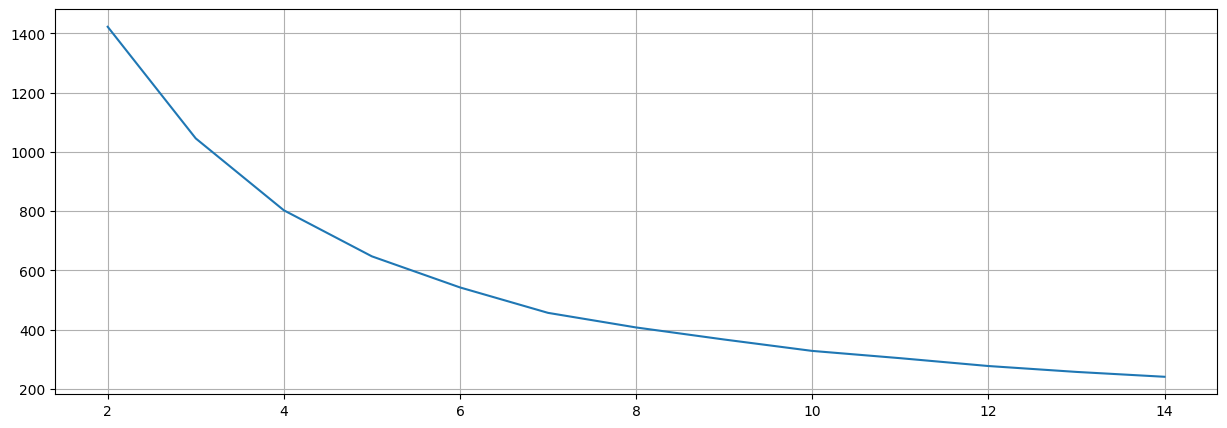

In [23]:
plt.figure(figsize=(15,5))
plt.plot(n_clusters, wcss)
plt.grid()
plt.show()

- Podemos observar que o melhor valor de K é 4 grupos. Para este estudo usaremos 4, caso fosse um projeto real contactaria-mos com o time de negócios para determinar estes valores.

In [24]:
km = KMeans(n_clusters=4, random_state=42)
x_trasf = km.fit_predict(x)
x_trasf

array([1, 3, 1, ..., 2, 3, 2])

In [25]:
data.loc[:,'cluster'] = x_trasf
data

,sex,marital_status,age,education,income,occupation,settlement_size,cluster
0,0,0,4.204693,2,11.733426,1,2,1
1,1,1,3.091042,1,11.923531,1,2,3
2,0,0,3.891820,1,11.398748,0,0,1
3,0,0,3.806662,1,12.052717,1,1,0
4,0,0,3.970292,1,11.911910,1,1,0
...,...,...,...,...,...,...,...,...
1995,1,0,3.850148,1,11.724199,0,0,1
1996,1,1,3.295837,1,11.676268,1,0,3
1997,0,0,3.433987,0,11.366743,0,0,2
1998,1,1,3.178054,1,11.492396,0,0,3


## Análise dos clusters

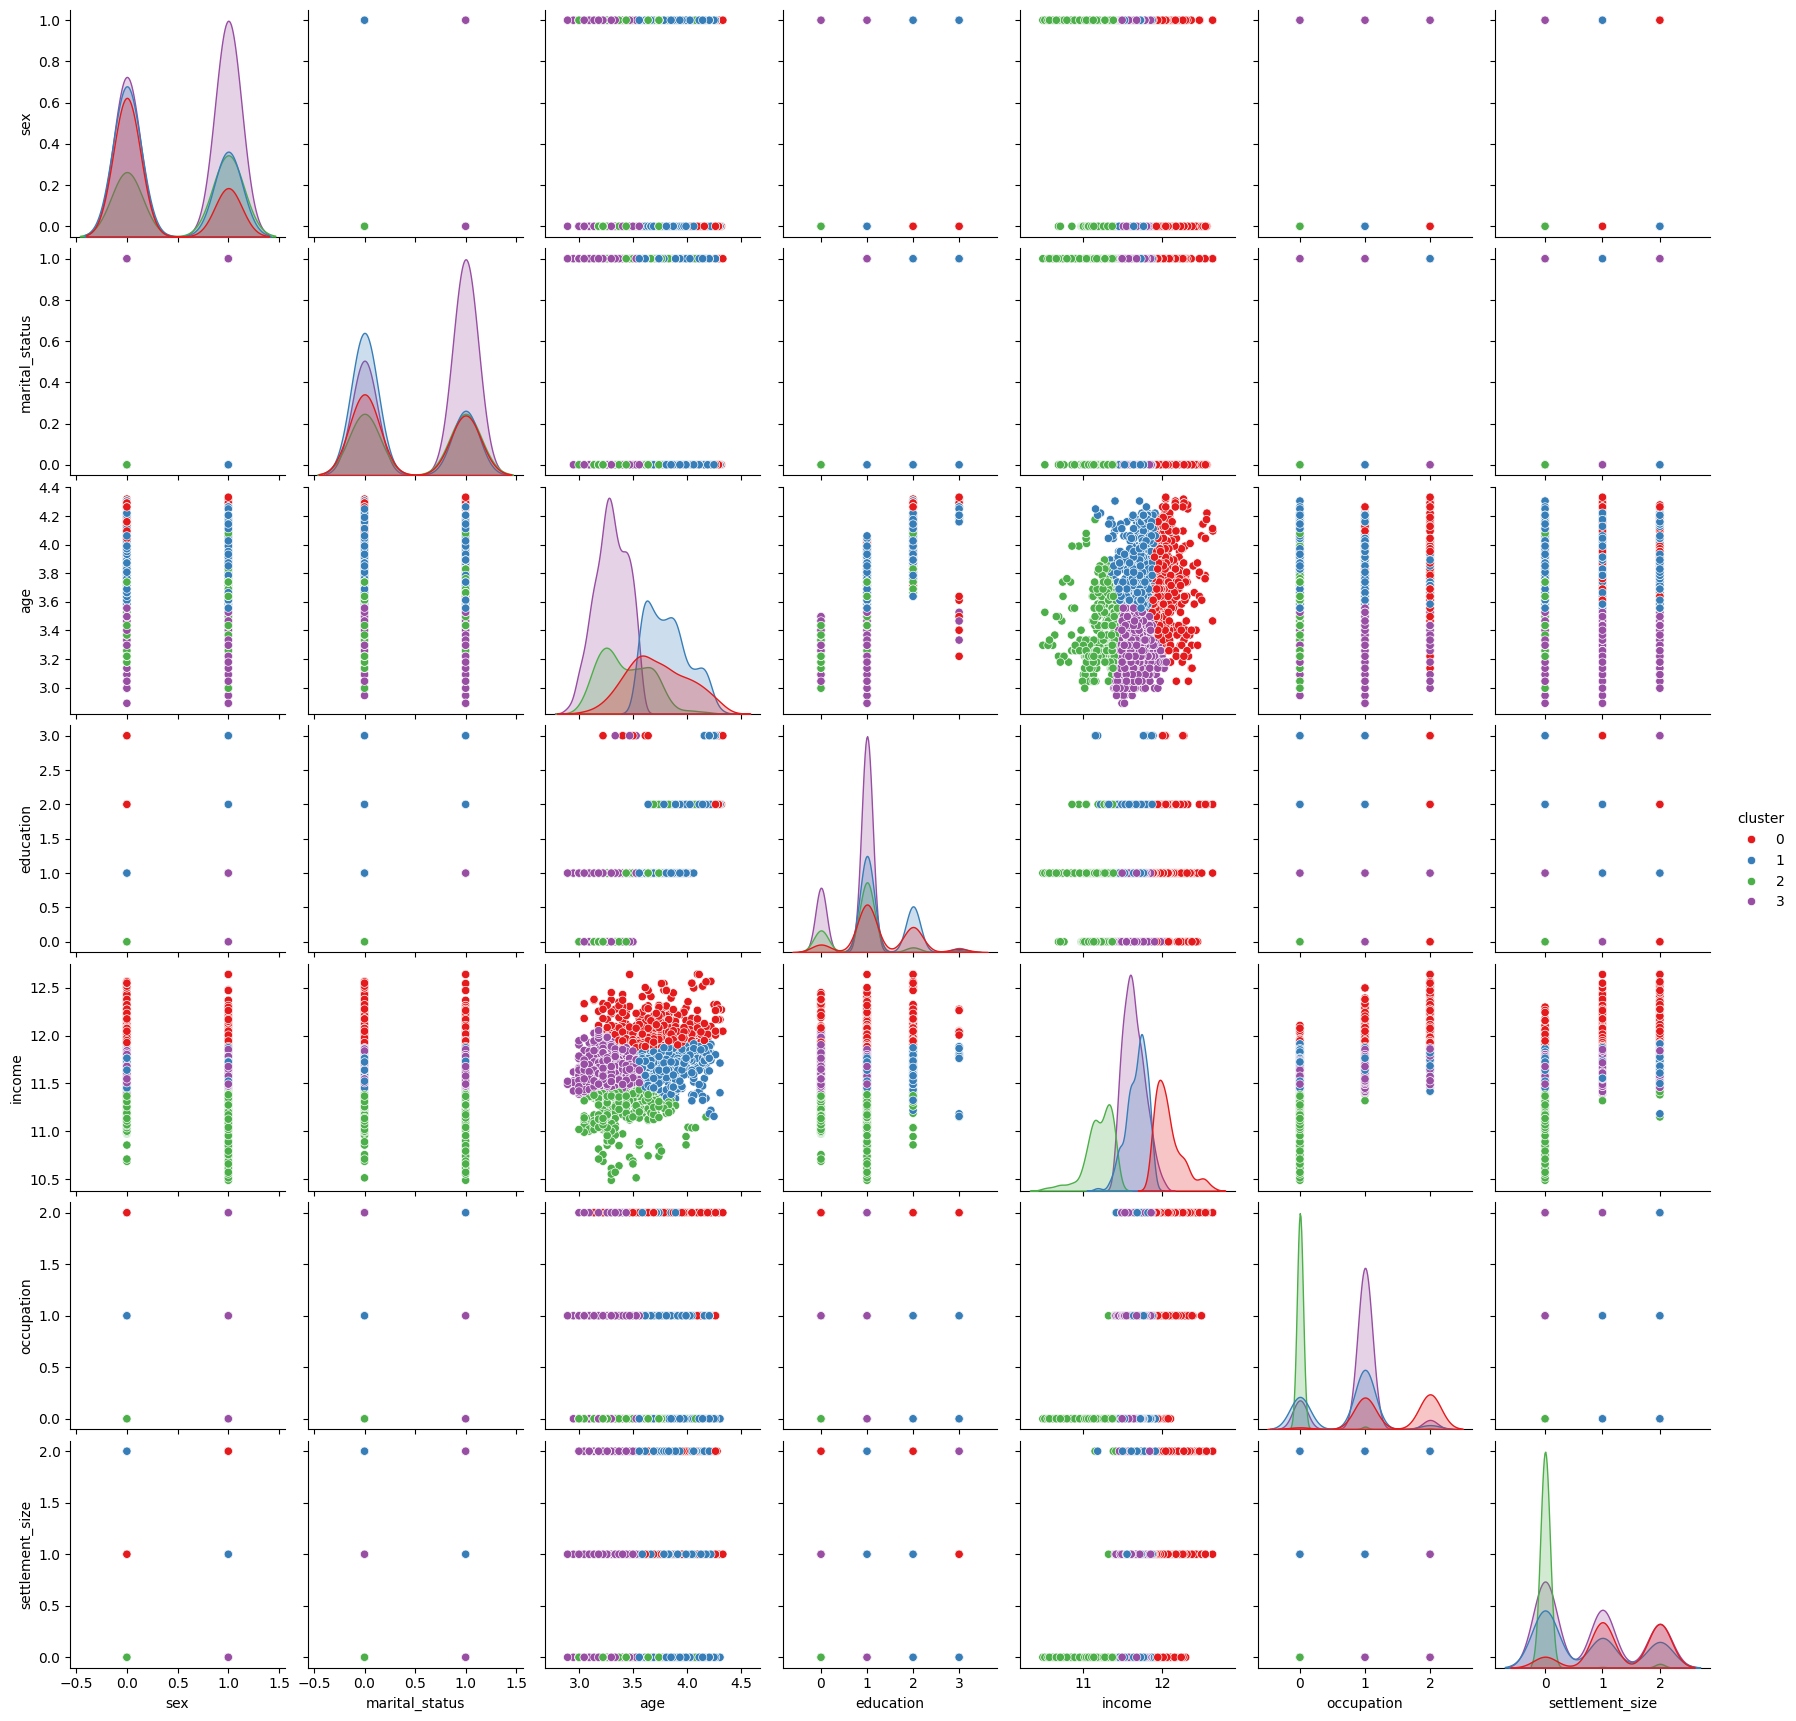

In [26]:
sns.pairplot(data, hue='cluster', palette='Set1')
plt.show()

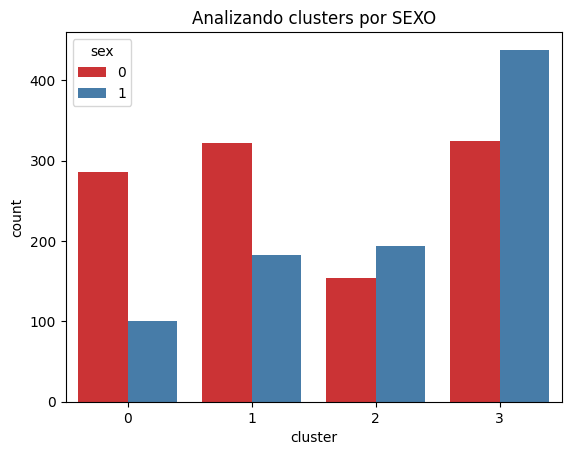

 0 - Homens
 1 - Mulheres


In [27]:
# cluster x sexo
sns.countplot(data=data, x='cluster', hue='sex', palette='Set1')
plt.title('Analizando clusters por SEXO')
plt.show()
print(' 0 - Homens\n 1 - Mulheres')

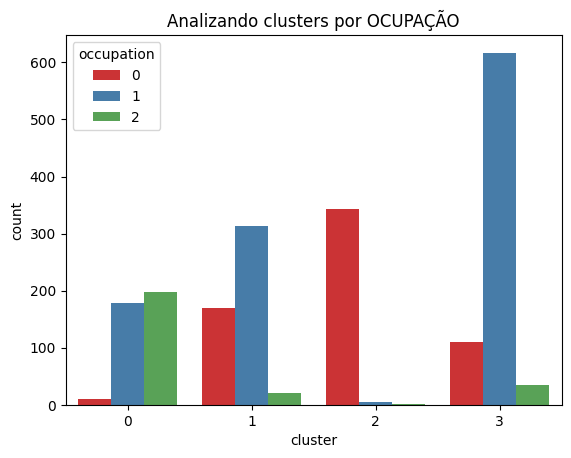

 0 - Desempregado
 1 - Funcionário Qualificado
 2 - Altamente Qualificado


In [28]:
# cluster x ocupação
sns.countplot(data=data, x='cluster', hue='occupation', palette='Set1')
plt.title('Analizando clusters por OCUPAÇÃO')
plt.show()
print(' 0 - Desempregado\n 1 - Funcionário Qualificado\n 2 - Altamente Qualificado')

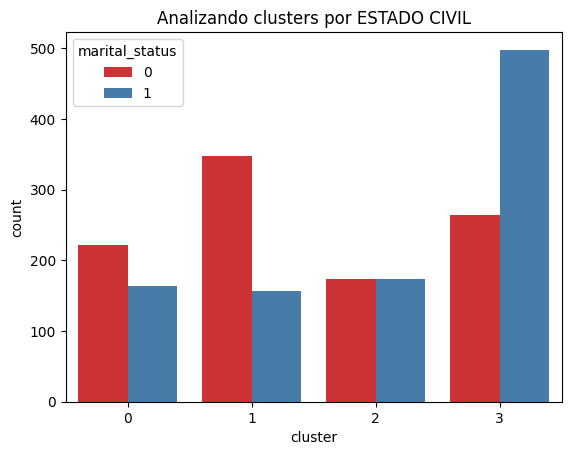

 0 - Solteiro
 1 - Não solteiro


In [29]:
# cluster x estado civil
sns.countplot(data=data, x='cluster', hue='marital_status', palette='Set1')
plt.title('Analizando clusters por ESTADO CIVIL')
plt.show()
print(' 0 - Solteiro\n 1 - Não solteiro')

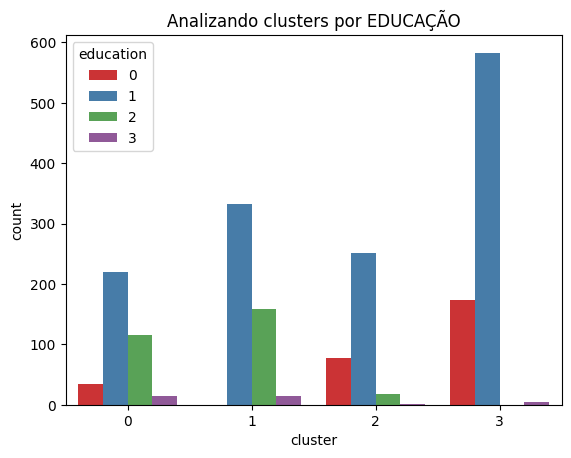

 0 - Desconhecido
 1 - Ensino médio
 2 - Universidade
 3 - Pós-Graduação


In [30]:
# cluster x educação
sns.countplot(data=data, x='cluster', hue='education', palette='Set1')
plt.title('Analizando clusters por EDUCAÇÃO')
plt.show()
print(' 0 - Desconhecido\n 1 - Ensino médio\n 2 - Universidade\n 3 - Pós-Graduação')

In [39]:
data.loc[(data['cluster'] == 3) & (data['education'] == 2)].count()

sex                0
marital_status     0
age                0
education          0
income             0
occupation         0
settlement_size    0
cluster            0
dtype: int64

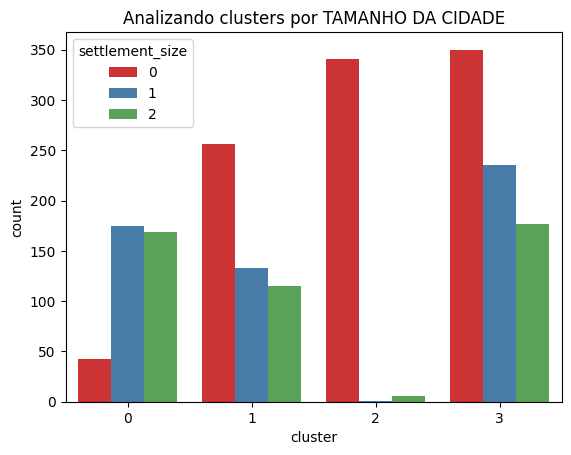

 0 - Cidade Pequena
 1 - Cidade Média
 2 - Cidade Grande


In [31]:
# cluster x tamanho da cidade
sns.countplot(data=data, x='cluster', hue='settlement_size', palette='Set1')
plt.title('Analizando clusters por TAMANHO DA CIDADE')
plt.show()
print(' 0 - Cidade Pequena\n 1 - Cidade Média\n 2 - Cidade Grande')

In [40]:
data['cluster'].value_counts()

cluster
3    762
1    504
0    386
2    348
Name: count, dtype: int64

In [53]:
# calcula a renda média de cada grupo
data.groupby('cluster')['income'].mean()

cluster
0    12.078442
1    11.676077
2    11.196773
3    11.639746
Name: income, dtype: float64

## Conclusões:

#### Perfís dos grupos:
- **Grupo 0 (Vermelho)** - Grupo com maior quantidade de homens, baixa taxa de desempregados e grupo com maior quantidade de pessoas altamente qualificadas, em sua maioria são solteiros, níveis de educação equilibrada mas com uma leve majoritariedade para quem tem ensino médio ou é/foi universitário e residem em cidades de médio/grande desenvolvimento. Este grupo 

- **Grupo 1 (Azul)** - Predominantemente masculino, possui uma taxa baixíssima de pessoas altamente qualificadas, possui uma alta contagem de desempregados, é o grupo com maior registro de solteiros, o grupo apresenta a melhor diversificação na educação, também um bom equilíbrio entre o tamanho da cidade em que residem mas apresenta uma quantidade maior em cidades pequenas.

- **Grupo 2 (Verde)** - O grupo mais equilibrado em sexo, dando um destaque para as mulheres que estão levemente em maior quantidade, o grupo quase que 100% é formado de pessoas desempregadas, quantidade muito parecida entre solteiros e relacionados, sua educação é mais concentrada no ensino médio e sua esmagadora maioria reside em cidades pequenas.

- **Grupo 3 (Roxo)** - Grupo majoritário feminino, maior quantidade de profissionais de nível qualificado, grande quantidade de pessoas em um relacionamento, grupo com  a maior quantidade de pessoas com ensino médio nenhum universitário

O grupo 0 se destaca porque apresenta pessoas de perfil com um grande poder aquisitivo e um nível de conhecimento acima da média, se fosse do ponto de vista de negócio mais "premium" seria nosso publico alvo. O grupo 1 possivelmente seria o grupo de estudantes ou pessoas no inicio de carreira, que buscam um certo desenvolvimento. O grupo 2 aparentemente é o pior se caso nosso interesse seja um publico alvo para vendas pois apresentam a menor renda média e maior quantidade de desempregados. O grupo 3 possivelmente pode ser o grupo de familias. 
